# 将数据加载到网络

训练一个机器学习深度学习模型一般可以简单概括为以下三个步骤：

- 准备数据
- 定义网络结构
- 训练

我们可以把整个过程用下面的一个Pipeline图例来表示。

其中的`reader`就主要负责把数据按一定的格式`feed`到深度学习网络的输入层上。不同的深度学习框架对为放进网络中的数据格式要求不一样。在MXNet中对于Module的训练与推理接口要求的数据都是一个`data iterator`。下面我们会详细来介绍MXNet中的Data Iterator。

## MXNet Data Iterator

MXNet里的Date Iterators与Python中的iterator object非常类似。在Python中，有一类被称为iterable的对象，它允许我们使用其中的`next`方法来顺序的抽取元素，比如list。迭代法器提供了一种遍历整个容器的简便方法，而不用关心容器具体的内容。

在MXNet中，`data iterators`每次返回一个`DataBatch`。一个`DataBatch`一般包含`n`个训练样本以及它们对应的标签。这里的`n`一般等于指定的batch size，当整个数据流迭代到尾巴，没有更多的数据返回时，迭代器将返回一个`StopIteration`的异常。DataBatch里包含了一些关于样本的信息：名称，形状，数据类型以及内在布局，可以通过`provide_data`和`provide_label`这两个访法返回的`DataDesc`对象来获取。

所有MXNet关于IO的处理都是由`mx.io.DataIter`以及它的子类来完成的。

下面我们通过使用几个典型的DataIter来说明它的用法。

## 从内存中读取数据

当数据是在内存中，以NDArray或者numpy中的ndarray的形式存在时，我们可以使用`NDArrayIter`来读取。

In [1]:
import mxnet as mx
%matplotlib inline
import os
import sys
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import tarfile

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import numpy as np
data = np.random.rand(100,3)
label = np.random.randint(0, 10, (100,))
data_iter = mx.io.NDArrayIter(data=data, label=label, batch_size=30)
for batch in data_iter:
    print([batch.data, batch.label, batch.pad])

[[
[[ 0.2741341   0.85484147  0.80102921]
 [ 0.40485328  0.94399148  0.35237792]
 [ 0.80163676  0.65552342  0.70672494]
 [ 0.6002304   0.80349803  0.86021811]
 [ 0.29902089  0.22871181  0.24943879]
 [ 0.59759891  0.72705346  0.40750921]
 [ 0.5451709   0.34972012  0.19003709]
 [ 0.70011538  0.89012575  0.9803735 ]
 [ 0.76334929  0.29479164  0.86896253]
 [ 0.09295708  0.82892334  0.53560883]
 [ 0.88645989  0.83093148  0.45425281]
 [ 0.47297829  0.41141093  0.82397914]
 [ 0.21961132  0.55650222  0.398655  ]
 [ 0.3018508   0.73762357  0.80428153]
 [ 0.78926343  0.4488343   0.63692182]
 [ 0.18280068  0.48577902  0.45698807]
 [ 0.50946671  0.16366318  0.41914722]
 [ 0.25504732  0.63336164  0.56954622]
 [ 0.93591529  0.3274256   0.10036603]
 [ 0.58884579  0.75215364  0.22205074]
 [ 0.45133024  0.29352146  0.36509734]
 [ 0.48764917  0.43407521  0.65954751]
 [ 0.13061005  0.79664528  0.29510614]
 [ 0.44367659  0.55578077  0.15880275]
 [ 0.0237996   0.29748446  0.98014647]
 [ 0.58766049  0.15085

## 从CSV文件中读取数据

MXNet提供了`CSVIter`来方便使用者直接从一个CSV文件中读取数据

In [ ]:
#lets save `data` into a csv file first and try reading it back
np.savetxt('data.csv', data, delimiter=',')
data_iter = mx.io.CSVIter(data_csv='data.csv', data_shape=(3,), batch_size=30)
for batch in data_iter:
    print([batch.data, batch.pad])

## 自定义一个数据迭代器

当MXNet提供的一些数据迭代器不满足我们的需求时，我们可以自己写一个数据迭代器。那么一个数据迭代器的对象，一定要包括下面几个方法：

- 实现`__next()__`(python3)，该方法返回一个DataBatch对象，并且当没有剩余数据时，返回一个`StopIteration`的异常
- 实现`reset()`方法用于重置数据读取到开始的位置
- 提供了`provide_data`属性，它是一个DataDesc对象的list，存储了数据的名称，形状，数据类型及内在布局信息。
- 提供了`provide_label`属性，它是一个DataDesc对象的list，存储了标签的名称，形状，数据类型及内在布局信息。

当我们创建一个新的iterator时，我们可以选择从头创建，也可以选择从一个已经存在的迭代器那扩展。比如果我们要做图像描述(image captioning)的应用。那输入的数据是图像，而对应的Label是一个句子。那我们可以使用`ImageRecordIter`创建一个`image_iter`，然后通过`NDArrayIter`创建一个`caption_iter`。我们的`nxet()`方法将返回`image_iter.next()`与`caption_iter.next()`的一个合并。

下面是我们自定义的一个迭代器。

In [5]:
class SimpleIter(mx.io.DataIter):
    def __init__(self, data_names, data_shapes, data_gen,
                 label_names, label_shapes, label_gen, num_batches=10):
        self._provide_data = list(zip(data_names, data_shapes))
        self._provide_label = list(zip(label_names, label_shapes))
        self.num_batches = num_batches
        self.data_gen = data_gen
        self.label_gen = label_gen
        self.cur_batch = 0

    def __iter__(self):
        return self

    def reset(self):
        self.cur_batch = 0

    def __next__(self):
        return self.next()

    @property
    def provide_data(self):
        return self._provide_data

    @property
    def provide_label(self):
        return self._provide_label

    def next(self):
        if self.cur_batch < self.num_batches:
            self.cur_batch += 1
            data = [mx.nd.array(g(d[1])) for d,g in zip(self._provide_data, self.data_gen)]
            label = [mx.nd.array(g(d[1])) for d,g in zip(self._provide_label, self.label_gen)]
            return mx.io.DataBatch(data, label)
        else:
            raise StopIteration

## Record IO

Record IO是MXNet为了数据IO设计的一种文件格式。它将数据打包成一种十分便于在分布式存储系统，如HDFS和AWS S3上进行高效读取的数据块。MXNet提供了`MXRecordIO`用于顺序数据存储的情况，提供了`MXIndexedRecordIO`用于随机数据存取的情况。

### MXRecordIO

我们先通过一个例子说明MXRecordIO用于顺序数据读写的用法。

In [6]:
def str_or_bytes(str):
    """
    A utility function for this tutorial that helps us convert string 
    to bytes if we are using python3.

    Parameters
    ----------
    str : string

    Returns
    -------
    string (python2) or bytes (python3)
    """
    if sys.version_info[0] < 3:
        return str
    else:
        return bytes(str, 'utf-8')

我们将几个连续的字符串写到一个以`.rec`结尾的文件中

In [8]:
record = mx.recordio.MXRecordIO('tmp.rec', 'w')
for i in range(5):
    record.write(str_or_bytes('record_%d'%i))

record.close()

我们再从一个`.rec`文件中来顺序的读取

In [9]:
record = mx.recordio.MXRecordIO('tmp.rec', 'r')
while True:
    item = record.read()
    if not item:
        break
    print (item)
record.close()

b'record_0'
b'record_1'
b'record_2'
b'record_3'
b'record_4'


不同与MXRecordIO对象，我们只能不断的调用`read()`方法来顺序的获取里面的数据。`MXIndexedRecordIO`可以随机的访问。

In [10]:
record = mx.recordio.MXIndexedRecordIO('tmp.idx', 'tmp.rec', 'w')
for i in range(5):
    record.write_idx(i, str_or_bytes('record_%d'%i))

record.close()

In [11]:
record = mx.recordio.MXIndexedRecordIO('tmp.idx', 'tmp.rec', 'r')
record.read_idx(3)

b'record_3'

In [13]:
# 也可以单独的把index输出出来
record.keys

[0, 1, 2, 3, 4]

## 打包和解包

我们放到`RecordIO`里面包含的是一个个pack，它可以是任何二进制数据。但是对于大部分深度学习的任务来说，我们往往需要的是`数据/标签`这样的格式。`mx.recordio`提供了一些接口函数来进行这些操作。

### Packing/Unpacking Binary Data

In [14]:
# pack
data = 'data'
label1 = 1.0
header1 = mx.recordio.IRHeader(flag=0, label=label1, id=1, id2=0)
s1 = mx.recordio.pack(header1, str_or_bytes(data))

label2 = [1.0, 2.0, 3.0]
header2 = mx.recordio.IRHeader(flag=3, label=label2, id=2, id2=0)
s2 = mx.recordio.pack(header2, str_or_bytes(data))

In [15]:
# unpack
print(mx.recordio.unpack(s1))
print(mx.recordio.unpack(s2))

(HEADER(flag=0, label=1.0, id=1, id2=0), b'data')
(HEADER(flag=3, label=array([ 1.,  2.,  3.], dtype=float32), id=2, id2=0), b'data')


### Packing/Unpacking Image Data

In [3]:
data = np.ones((3,3,1), dtype=np.uint8)
label = 1.0
header = mx.recordio.IRHeader(flag=0, label=label, id=0, id2=0)
s = mx.recordio.pack_img(header, data, quality=100, img_fmt='.jpg')

In [4]:
# unpack_img
print(mx.recordio.unpack_img(s))

(HEADER(flag=0, label=1.0, id=0, id2=0), array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=uint8))


## 图像IO

当我们做计算机视频方面的应用时，要处理的大部分数据都是图像与视频（也会拆成视频帧处理）。所以我们这个小节重点介绍在MXNet中是如何处理输入数据为图像的场景的。

有4种方法可以让我们选择来把数据加载到MXNet中

1. 使用`mx.image.imdecode`来加载原始的图像数据
2. 使用`mx.img.ImageIter`它是用Python来实现的，比较灵活，方便我们修改 ，它可以读取.rec的文件或者原始文件。
3. 使用`mx.io.ImageRecordIter`它在MXNet中是放在后端用C++实现的，所以不太便于修改。
4. 自己基于`mx.io.DataIter`写一个自己的迭代器

### 图像的处理

In [20]:
fname = mx.test_utils.download(url='http://data.mxnet.io/data/test_images.tar.gz', dirname='data', overwrite=False)
tar = tarfile.open(fname)
tar.extractall(path='./data')
tar.close()

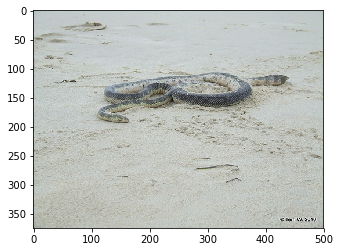

In [21]:
img = mx.image.imdecode(open('data/test_images/ILSVRC2012_val_00000001.JPEG', 'rb').read())
plt.imshow(img.asnumpy()); plt.show()

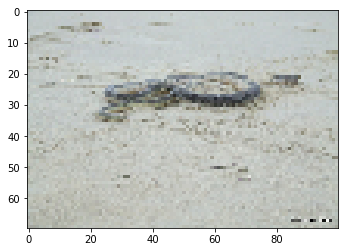

In [22]:
# resize to w x h
tmp = mx.image.imresize(img, 100, 70)
plt.imshow(tmp.asnumpy()); plt.show()

(139, 26, 150, 200)


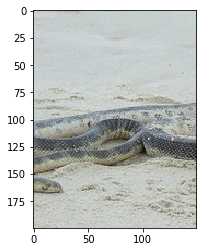

In [23]:
# crop a random w x h region from image
tmp, coord = mx.image.random_crop(img, (150, 200))
print(coord)
plt.imshow(tmp.asnumpy()); plt.show()

### 通过Image Iterators来加载图片

我们先下载一个数据集，Caltech 101，它包含了101类物体。我们先将它转换成RecordIO格式文件。

In [ ]:
fname = mx.test_utils.download(url='http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz', dirname='data', overwrite=False)
tar = tarfile.open(fname)
tar.extractall(path='./data')
tar.close()

我们先看一下这个数据集，在根目录下（./data/101_ObjectCategories），每一个类别都是一个子文件平。我们可以使用脚本`im2rec.py`来将整个目录转化为成ReecordIO文件。第一步，我们把所有的图片路径以及它们的label列到一个文本中。

In [ ]:
os.system('python %s/tools/im2rec.py --list=1 --recursive=1 --shuffle=1 --test-ratio=0.2 data/caltech data/101_ObjectCategories'%os.environ['MXNET_HOME'])

上面的命令会生成一个caltech_train.lst的文件，文件的内容是`index\t(one or more label)\tpath`的格式。在这个例子中，只有一个label。然后我们就可以用这个文件列表信息云生成我们的RecordIO文件了。

In [ ]:
os.system("python %s/tools/im2rec.py --num-thread=4 --pass-through=1 data/caltech data/101_ObjectCategories"%os.environ['MXNET_HOME'])

`ImageRecordIter`可以通过RecordIO格式来加载图片数据。

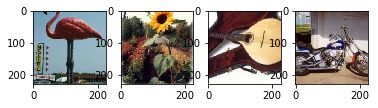

In [26]:
data_iter = mx.io.ImageRecordIter(
    path_imgrec="./data/caltech.rec", # the target record file
    data_shape=(3, 227, 227), # output data shape. An 227x227 region will be cropped from the original image.
    batch_size=4, # number of samples per batch
    resize=256 # resize the shorter edge to 256 before cropping
    # ... you can add more augumentation options as defined in ImageRecordIter.
    )
data_iter.reset()
batch = data_iter.next()
data = batch.data[0]
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(data[i].asnumpy().astype(np.uint8).transpose((1,2,0)))
plt.show()

除了`ImageRecordIter`外，我们可以使用`ImageIter`来读取一个RecordIO文件或者直接读取原始格式的文件。

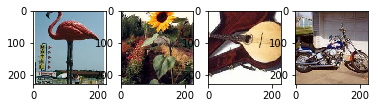

In [27]:
data_iter = mx.image.ImageIter(batch_size=4, data_shape=(3, 227, 227),
                              path_imgrec="./data/caltech.rec",
                              path_imgidx="./data/caltech.idx" )
data_iter.reset()
batch = data_iter.next()
data = batch.data[0]
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(data[i].asnumpy().astype(np.uint8).transpose((1,2,0)))
plt.show()